In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
import statistics

In [2]:
mkfunc2 = lambda x, pos: "2/"+time.ctime(x+9*3600)[8:16]
mkformatter2 = matplotlib.ticker.FuncFormatter(mkfunc2)

In [3]:
with open("runtimes.csv","r") as fd: lines=fd.readlines()


In [4]:
def parse(lines, cpus=2, sstrs=["2"]):
    data={}
    for line in lines[1:]:
      larr=line.strip().split(",")
      #print(larr)
      if len(larr)!=9:
        continue

      found=False
      for sstr in sstrs:
        if larr[8].strip().startswith(sstr):
          found=True
      if not found:
        continue

      if int(float(larr[1].strip()))!=cpus:
        continue
        
      narr=larr[6].strip().split(".")
      n=narr[1] # node name
      d=narr[-1] #domain
      k = larr[3].strip()
      if k=="":
          kidx=int(larr[4].split('/')[1])
          if kidx<1:
            k="A100-SXM4-40GB MIG 7g.40gb"
          elif kidx<3:
            k="A100-SXM4-40GB MIG 3g.20gb"
          elif kidx<7:
            k="A100-SXM4-40GB MIG 2g.10gb"
          else:
            k="A100-SXM4-40GB MIG 1g.5gb"
      if d=="com": # google
        if n.find("ts")<0:
            mtype=n.split("-")[2]
        else:
            mtype=n.split("-")[3]
        if mtype.startswith("pa100m"):
            mtype=mtype[6:]+"xMIG"
        elif mtype.startswith("pa100t"):
            mtype=mtype[6:]+"xshared"
        elif mtype.startswith("pv100t"):
            mtype=mtype[6:]+"xshared"
        elif mtype.startswith("pt4t"):
            mtype=mtype[4:]+"xshared"
        else:
            mtype=""

        k=k + " gke " + mtype
      elif d=="io":
        k=k+ " prp"
        if k.find("MIG 2g.10gb")>=0:
            k=k+" 3xMIG"
        elif k.find("MIG 3g.20gb")>=0:
            k=k+" 2xMIG"
      else:
        #k=k+ " unknown"
        continue # old style, ignore

      val=int(larr[7])

      if k not in data:
        data[k]=[]
      data[k].append(val)
    return data


In [5]:
def get_means(data, maxv=360000):
    means={}
    stdevs={}
    medians={}
    throughput={}
    thstdevs={}
    for k in data:
        multiplier=1
        midx=k.find("xMIG")
        if midx>0:
            multiplier=int(k[midx-1])
        else:
            midx=k.find("xsha")
            if midx>0:
                multiplier=int(k[midx-1])
        #print(k,multiplier)
        els=[]
        rels=[]
        for val in data[k]:
            if val<maxv: # strip out outliers
                els.append(val)
                rels.append(multiplier*24*3600.0/val)
        means[k] = statistics.mean(els)
        stdevs[k] = statistics.stdev(els)
        medians[k] = statistics.median(els)
        throughput[k] = statistics.mean(rels)
        thstdevs[k] = statistics.stdev(rels)
    return (means,stdevs,medians,throughput,thstdevs)

In [6]:
def save(data,means,stdevs,medians,throughput,thstdevs,fname):
    with open(fname,"w") as fd:
        fd.write("#GPU, mean, stdev, median, throughput_day, throughput_stdev\n")
        klist=list(data.keys())
        klist.sort()
        for k in klist:
            fd.write("#%s, %i, %i, %i, %.2f, %.2f\n"%(k,means[k],stdevs[k],medians[k],throughput[k],thstdevs[k]))

In [7]:
def hvals(data, minv=0, maxv=360000, bins=20):
    rtimes=set()
    for k in data:
        rtimes = rtimes.union(data[k])

    rmin=max( (min(rtimes),minv) )
    rmax=min( (max(rtimes),maxv) )+1
    dr=(rmax-rmin)/float(bins)
    del rtimes
    
    data_times=[]
    data_values={}
    for k in data:
        data_values[k] = []
    for i in range(bins):
        data_times.append(int(rmin+dr/2+dr*i))
        for k in data:
            data_values[k].append(0)
    for k in data:
        nels=len(data[k])
        for ival in data[k]:
            val = min(max(rmin,ival),rmax-1) 
            b=int((val-rmin)/dr)
            data_values[k][b]+=1.0/nels
    return (data_times, data_values)

In [8]:
data=parse(lines, 2,["2022-03"])
means,stdevs,medians,throughput,thstdevs=get_means(data)
save(data,means,stdevs,medians,throughput,thstdevs,"runtimes.o1.all_c2.csv")
rtimes,rvals=hvals(data,maxv=40000,bins=30)

In [9]:
#print(data.keys())
#print(rtimes)
#print(rvals)

   71 26119 26136    23 A100-SXM4-40GB MIG 1g.5gb gke 7xMIG
   54 13202 13212    19 A100-SXM4-40GB MIG 2g.10gb gke 3xMIG
   50  8958  8964    19 A100-SXM4-40GB MIG 3g.20gb gke 2xMIG
   29  7267  7307    11 A100-SXM4-40GB MIG 7g.40gb gke 1xMIG
    7  7297  7307    11 A100-SXM4-40GB gke 
   11  8355  8388    20 A100-SXM4-40GB gke 2xshared
   10 11451 11430    22 A100-SXM4-40GB gke 3xshared
   25 15151 15336    22 A100-SXM4-40GB gke 4xshared
   35 26807 26820    22 A100-SXM4-40GB gke 7xshared
  120  9370  9360    18 NVIDIA A100-PCIE-40GB MIG 3g.20gb prp 2xMIG
   38  4476  4500    19 NVIDIA A100-PCIE-40GB prp


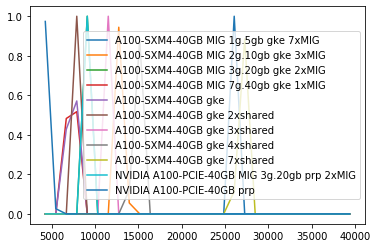

In [10]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend()
plt.show()

  120  9370  9360    18 NVIDIA A100-PCIE-40GB MIG 3g.20gb prp 2xMIG
   38  4476  4500    19 NVIDIA A100-PCIE-40GB prp


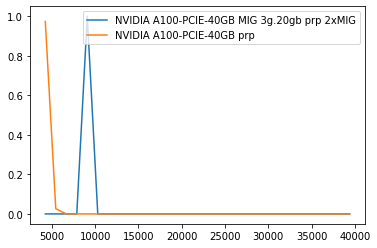

In [11]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    if k.find("prp")<0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o1_prp_a100mig.png", format="png")
plt.savefig("o1_prp_a100mig.svg", format="svg")
plt.show()



    7  7297  7307    11 A100-SXM4-40GB gke 
   11  8355  8388    20 A100-SXM4-40GB gke 2xshared
   10 11451 11430    22 A100-SXM4-40GB gke 3xshared
   25 15151 15336    22 A100-SXM4-40GB gke 4xshared
   35 26807 26820    22 A100-SXM4-40GB gke 7xshared


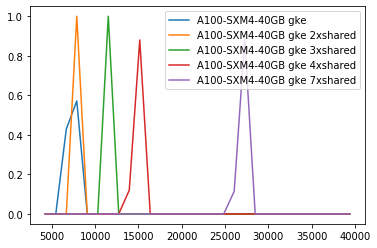

In [12]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    if k.find("prp")>=0:
        continue
    if k.find("MIG")>=0:
        continue


    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o1_gke_a100shr.png", format="png")
plt.savefig("o1_gke_a100shr.svg", format="svg")
plt.show()

   71 26119 26136    23 A100-SXM4-40GB MIG 1g.5gb gke 7xMIG
   54 13202 13212    19 A100-SXM4-40GB MIG 2g.10gb gke 3xMIG
   50  8958  8964    19 A100-SXM4-40GB MIG 3g.20gb gke 2xMIG
   29  7267  7307    11 A100-SXM4-40GB MIG 7g.40gb gke 1xMIG


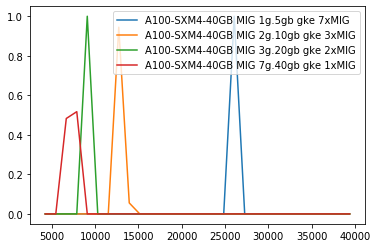

In [13]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("A100")<0:
        continue
    if k.find("MIG")<0:
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o1_gke_a100mig.png", format="png")
plt.savefig("o1_gke_a100mig.svg", format="svg")
plt.show()

   20  7849  7794    11 Tesla V100-SXM2-16GB gke 
   60 14239 14238    12 Tesla V100-SXM2-16GB gke 2xshared


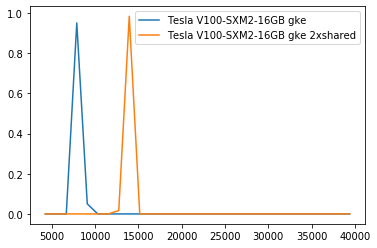

In [14]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o1_gke_v100shr.png", format="png")
plt.savefig("o1_gke_v100shr.svg", format="svg")
plt.show()

   42 11464 11466     7 Tesla T4 gke 
   41 24485 24552     7 Tesla T4 gke 2xshared


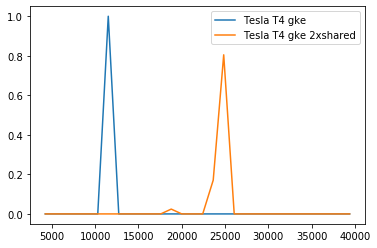

In [15]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla T"):
        continue
    if k.find("prp")>=0:
        continue

    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %5i %s"%(len(data[k]),means[k],medians[k],throughput[k],k))
plt.legend(loc=1)
plt.savefig("o1_gke_t4shr.png", format="png")
plt.savefig("o1_gke_t4shr.svg", format="svg")
plt.show()

In [16]:
#data=parse(lines,2,"2022-03")
#means,medians=get_means(data)
#rtimes,rvals=hvals(data,bins=20)
#save(data,means,medians,"runtimes.prp_c2.csv")

   71 26119 26136 A100-SXM4-40GB MIG 1g.5gb gke 7xMIG
   54 13202 13212 A100-SXM4-40GB MIG 2g.10gb gke 3xMIG
   50  8958  8964 A100-SXM4-40GB MIG 3g.20gb gke 2xMIG
   29  7267  7307 A100-SXM4-40GB MIG 7g.40gb gke 1xMIG
    7  7297  7307 A100-SXM4-40GB gke 
   11  8355  8388 A100-SXM4-40GB gke 2xshared
   10 11451 11430 A100-SXM4-40GB gke 3xshared
   25 15151 15336 A100-SXM4-40GB gke 4xshared
   35 26807 26820 A100-SXM4-40GB gke 7xshared
  120  9370  9360 NVIDIA A100-PCIE-40GB MIG 3g.20gb prp 2xMIG
   38  4476  4500 NVIDIA A100-PCIE-40GB prp
  505  4152  4032 NVIDIA A40 prp
   48 16479 16452 NVIDIA GeForce GTX 1070 prp
 2173  8977  8856 NVIDIA GeForce GTX 1080 Ti prp
  973 12359 12348 NVIDIA GeForce GTX 1080 prp
 3193  6350  6300 NVIDIA GeForce RTX 2080 Ti prp
  488  3887  3708 NVIDIA GeForce RTX 3090 prp
  229  5904  5724 NVIDIA TITAN RTX prp
   27  8185  8172 NVIDIA TITAN Xp prp
    5 43668 43560 Quadro M4000 prp
   42 11464 11466 Tesla T4 gke 
   41 24485 24552 Tesla T4 gke 2xshared


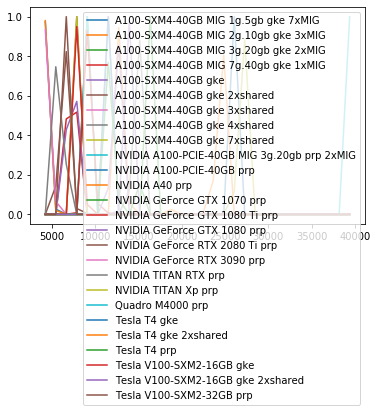

In [17]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    #if k.endswith("are"):
    #    continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()

  505  4152  4032 NVIDIA A40 prp
   48 16479 16452 NVIDIA GeForce GTX 1070 prp
 2173  8977  8856 NVIDIA GeForce GTX 1080 Ti prp
  973 12359 12348 NVIDIA GeForce GTX 1080 prp
 3193  6350  6300 NVIDIA GeForce RTX 2080 Ti prp
  488  3887  3708 NVIDIA GeForce RTX 3090 prp
  229  5904  5724 NVIDIA TITAN RTX prp
   27  8185  8172 NVIDIA TITAN Xp prp
    5 43668 43560 Quadro M4000 prp


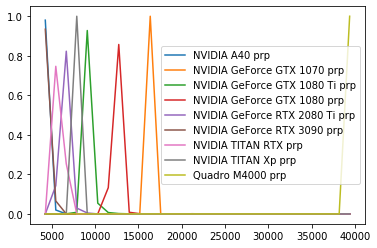

In [18]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if k.find("100")>0 or k.find("T4")>0:
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()